## Importing Libraries

In [261]:
import os
import faiss
from faiss import write_index, read_index
import torch
import re
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import os
import torch
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from io import StringIO
import glob
import time
from tqdm.notebook import tqdm

## Various Utilities (e.g., loading CLIP model, embedding functions, etc.)

In [2]:
# numbers = re.compile(r'(\d+)')
# def numericalSort(value):
#     parts = numbers.split(value)
#     parts[1::2] = map(int, parts[1::2])
#     return parts

########################## Reading all Images Path ##################################
file_path = "./../vector_search/static/*.png" ## Replace with your path if you need to create imageonly.csv file
def read_img_path(file):
        data = glob.glob(file, recursive=True)
        df = pd.DataFrame(data, columns = ['img_only'])
        return df

################################# CLIP MODEL ###################################

def get_model_info(model_ID, device):
    model = CLIPModel.from_pretrained(model_ID).to(device)
    processor = CLIPProcessor.from_pretrained(model_ID)
    tokenizer = CLIPTokenizer.from_pretrained(model_ID)
    return model, processor, tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"
model, processor, tokenizer = get_model_info(model_ID, device)

################################### IMAGE EMBEDDINGS ########################################

def get_single_text_embedding(text): 
    inputs = tokenizer(text, return_tensors = "pt").to(device)
    text_embeddings = model.get_text_features(**inputs)
     # convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

################################### TEXT EMBEDDINGS ########################################

def get_single_image_embedding(my_image):
    image = processor(text = None, images = my_image, return_tensors="pt")["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

2023-10-02 14:25:17.064045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 14:25:21.713852: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Processing metadata files and added the segmented images (i.e., subfigure_file) path to the metadata file in a new Column

In [126]:
metadata = pd.read_csv('./../vector_search/nipseval_50000_original.csv')
figure_file = metadata['subfigure_file'] ## this is the column of segemented images
img_path = "./../vector_search/static/"

lst1 = []
for i in figure_file:
    f = img_path+i
    lst1.append(f)

dataframe = pd.DataFrame(lst1, columns = ['figure_path'])
dataframe.to_csv('imagepath.csv', index = None)

In [127]:
img_path = pd.read_csv('imagepath.csv')
result = pd.concat([metadata, img_path], axis = 1)
result.to_csv('patent_67000_segmented_metadata.csv', index = None)

In [128]:
result.head()

,patentID,patentdate,figid,caption,object_infer,aspect,figure_file,subfigure_file,object_title,figure_path
0,USD0884696-20200519,2020-05-19,1,FIG. 1 is a perspective view of a display with...,display with connector and cover,perspective view,USD0884696-20200519-D00001.png,USD0884696-20200519-D00001_1.png,Display with connector and cover,./../vector_search/static/USD0884696-20200519-...
1,USD0884696-20200519,2020-05-19,2,FIG. 2 is a front view thereof;,display with connector and cover,front view,USD0884696-20200519-D00002.png,USD0884696-20200519-D00002_2.png,Display with connector and cover,./../vector_search/static/USD0884696-20200519-...
2,USD0884696-20200519,2020-05-19,3,FIG. 3 is a first side view thereof;,display with connector and cover,side view,USD0884696-20200519-D00003.png,USD0884696-20200519-D00003_3.png,Display with connector and cover,./../vector_search/static/USD0884696-20200519-...
3,USD0884696-20200519,2020-05-19,4,FIG. 4 is a second side view thereof;,display with connector and cover,side view,USD0884696-20200519-D00003.png,USD0884696-20200519-D00003_4.png,Display with connector and cover,./../vector_search/static/USD0884696-20200519-...
4,USD0884696-20200519,2020-05-19,5,FIG. 5 is a top view thereof;,display with connector and cover,top view,USD0884696-20200519-D00004.png,USD0884696-20200519-D00004_5.png,Display with connector and cover,./../vector_search/static/USD0884696-20200519-...


In [297]:
data = pd.read_csv('patent_67000_segmented_metadata.csv')
caps = data['object_infer']
viewpoint = data['aspect']
figure_path = data['figure_path']
title = data['object_title']

## Image Embeddings

In [78]:
img_embed = []
for img in tqdm(figure_path, desc = 'Image Embedding is Progress'):
    images = Image.open(img, 'r')
    image_embedding = get_single_image_embedding(images)
    img_embed.append(image_embedding)

Image Embedding is Progress:   0%|          | 0/67515 [00:00<?, ?it/s]

In [ ]:
torch.save(img_embed, 'image_embeddings_v1.pt')

## Text Embeddings

In [83]:
text_embed = []
for txt in tqdm(caps, desc = 'Text Embedding is in Progress'):
    text_embedding = get_single_text_embedding(txt)
    text_embed.append(text_embedding)

Text Embedding is in Progress:   0%|          | 0/67515 [00:00<?, ?it/s]

In [ ]:
torch.save(text_embed, 'text_embeddings_v1.pt')

## Creating Vector Database for Image

In [80]:
# ###### Load the image embedding ######
# embed = torch.load("./../vector_search/image_embeddings_v1.pt")
# embed_arr = np.array(embed)
# embed_slice = embed_arr[:,0,:] ## making the two dimensional array
# print(np.shape(embed_slice))

(67515, 512)


In [4]:
# img_embedding = embed_slice.shape[1]
# img_embedding

512

In [5]:
# index = faiss.IndexFlatL2(img_embedding)

In [6]:
# index.is_trained

True

In [7]:
# index.add(embed_slice)
# index.ntotal

67515

In [8]:
# write_index(index, "image.index")

## Create a Vector Database for Text

In [9]:
# ###### Load the text embedding ######

# txt_embed = torch.load("./../vector_search/text_embeddings.pt") ## Replace with your path
# txt_embed_arr = np.array(txt_embed)
# txt_embed_slice = txt_embed_arr[:,0,:] ## making the two dimensional array
# print(np.shape(txt_embed_slice))

(67515, 512)


In [10]:
# txt_embedding = embed_slice.shape[1]
# txt_embedding

512

In [11]:
# txt_index = faiss.IndexFlatL2(txt_embedding)

In [12]:
# txt_index.is_trained

True

In [13]:
# txt_index.add(embed_slice)
# txt_index.ntotal

67515

In [14]:
# write_index(txt_index, "text.index")

## Create a Vector Database with the concatnated version of image and text pairs

In [130]:
img_embed = torch.load("./../vector_search/image_embeddings_v1.pt") ## Replace with your path
txt_embed = torch.load("./../vector_search/text_embeddings_v1.pt") ## Replace with your path

img_embed_arr = np.array(img_embed)
img_embed_slice = img_embed_arr[:,0,:]

txt_embed_arr = np.array(txt_embed)
txt_embed_slice = txt_embed_arr[:,0,:]


concat = np.concatenate((img_embed, txt_embed), axis =1)
concat_arr = np.array(concat)
concat_slice = concat_arr[:,0,:]

concatanated = np.ascontiguousarray(concat_slice)

print(concatanated.flags)
print(np.shape(concatanated))

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

(67515, 512)


In [131]:
img_txt_embed = concatanated.shape[1]
img_txt_embed

512

In [173]:
nlist = 5
quantizer = faiss.IndexFlatL2(img_txt_embed)
img_txt_index = faiss.IndexIVFFlat(quantizer, img_txt_embed, nlist)

In [174]:
img_txt_index.is_trained

False

In [175]:
img_txt_index.train(concatanated)
img_txt_index.is_trained

True

In [176]:
img_txt_index.add(concatanated)
img_txt_index.ntotal

67515

In [177]:
write_index(img_txt_index, "large_v1.index")

## Loading Vector Database

In [178]:
idx = read_index("large_v1.index")

## Embed the Query Image

In [188]:
queryImage = Image.open("./../vector_search/static/USD0805066-20171212-D00001_1.png", 'r') ## Replace with your path
query_embedding = get_single_image_embedding(queryImage)

## Embed the Query Text

In [189]:
queryText = "Wristwatch"
query_embedding_txt = get_single_text_embedding(queryText)

## Search against the Vector Database

In [190]:
%%time
query = np.array(query_embedding) ## pass the array of either image or text of the user query
D, I = idx.search(query, k=9)
print(D)
print('\n')
print(I)

[[ 0.        8.414567 10.516537 16.263325 20.589006 21.507338 22.919922
  24.057926 24.838743]]


[[51944 51948 63476  2790  2798  2488 62209 55805 65478]]
CPU times: user 16.1 ms, sys: 971 µs, total: 17.1 ms
Wall time: 14.1 ms


## Displaying the Search Result of the Query Image

In [349]:
res = []
images = []
captions = []
for x in I:
    for pic in x:
        result = Image.open(fn1['figure_path'][pic], 'r')
        result = result.resize((200, 300))
        captions = caps[pic] + ", " + viewpoint[pic]
        images.extend((result, [captions]))

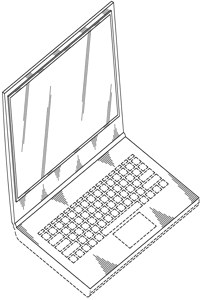

['laptop computer with antenna, front perspective view']

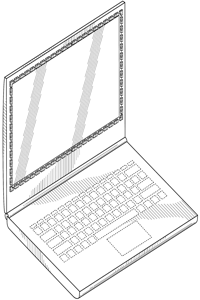

['laptop computer with antenna, front perspective view']

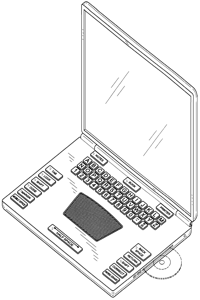

['electronic book with hinge connected touch screen, isometric view']

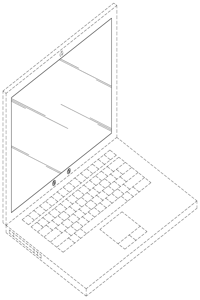

['display device with cameras, perspective view']

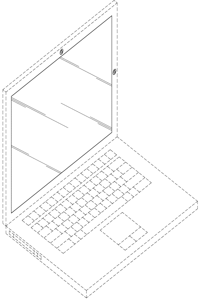

['display device with cameras, perspective view']

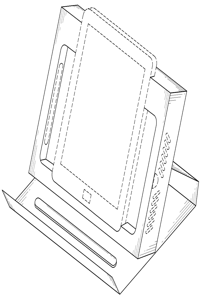

['protecting enclosure for portable electronic device, perspective view']

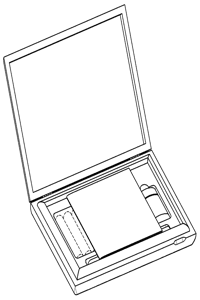

['cigar training kit, front perspective view']

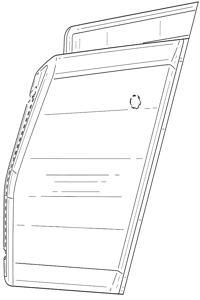

['bumper for a utility vehicle, right side view']

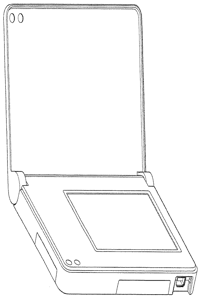

['wireless transmitter, front , left and bottom perspective view']

In [352]:
for pic in images:
    display(pic)

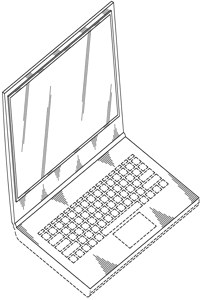

['laptop computer with antenna', 'front perspective view', 'laptop computer with antenna', 'front perspective view', 'electronic book with hinge connected touch screen', 'isometric view', 'display device with cameras', 'perspective view', 'display device with cameras', 'perspective view', 'protecting enclosure for portable electronic device', 'perspective view', 'cigar training kit', 'front perspective view', 'bumper for a utility vehicle', 'right side view', 'wireless transmitter', 'front , left and bottom perspective view']


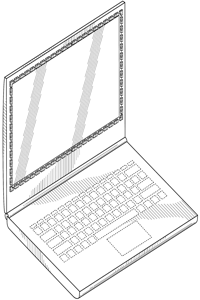

['laptop computer with antenna', 'front perspective view', 'laptop computer with antenna', 'front perspective view', 'electronic book with hinge connected touch screen', 'isometric view', 'display device with cameras', 'perspective view', 'display device with cameras', 'perspective view', 'protecting enclosure for portable electronic device', 'perspective view', 'cigar training kit', 'front perspective view', 'bumper for a utility vehicle', 'right side view', 'wireless transmitter', 'front , left and bottom perspective view']


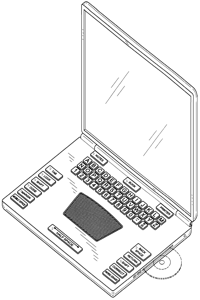

['laptop computer with antenna', 'front perspective view', 'laptop computer with antenna', 'front perspective view', 'electronic book with hinge connected touch screen', 'isometric view', 'display device with cameras', 'perspective view', 'display device with cameras', 'perspective view', 'protecting enclosure for portable electronic device', 'perspective view', 'cigar training kit', 'front perspective view', 'bumper for a utility vehicle', 'right side view', 'wireless transmitter', 'front , left and bottom perspective view']


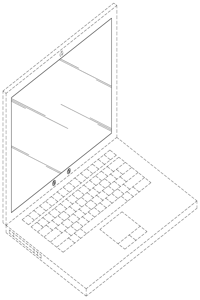

['laptop computer with antenna', 'front perspective view', 'laptop computer with antenna', 'front perspective view', 'electronic book with hinge connected touch screen', 'isometric view', 'display device with cameras', 'perspective view', 'display device with cameras', 'perspective view', 'protecting enclosure for portable electronic device', 'perspective view', 'cigar training kit', 'front perspective view', 'bumper for a utility vehicle', 'right side view', 'wireless transmitter', 'front , left and bottom perspective view']


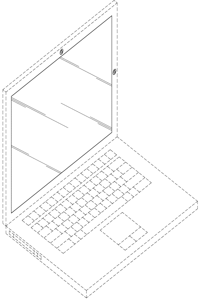

['laptop computer with antenna', 'front perspective view', 'laptop computer with antenna', 'front perspective view', 'electronic book with hinge connected touch screen', 'isometric view', 'display device with cameras', 'perspective view', 'display device with cameras', 'perspective view', 'protecting enclosure for portable electronic device', 'perspective view', 'cigar training kit', 'front perspective view', 'bumper for a utility vehicle', 'right side view', 'wireless transmitter', 'front , left and bottom perspective view']


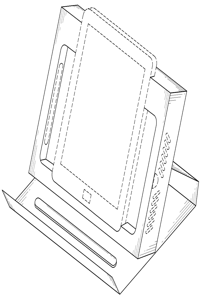

['laptop computer with antenna', 'front perspective view', 'laptop computer with antenna', 'front perspective view', 'electronic book with hinge connected touch screen', 'isometric view', 'display device with cameras', 'perspective view', 'display device with cameras', 'perspective view', 'protecting enclosure for portable electronic device', 'perspective view', 'cigar training kit', 'front perspective view', 'bumper for a utility vehicle', 'right side view', 'wireless transmitter', 'front , left and bottom perspective view']


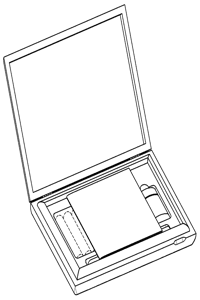

['laptop computer with antenna', 'front perspective view', 'laptop computer with antenna', 'front perspective view', 'electronic book with hinge connected touch screen', 'isometric view', 'display device with cameras', 'perspective view', 'display device with cameras', 'perspective view', 'protecting enclosure for portable electronic device', 'perspective view', 'cigar training kit', 'front perspective view', 'bumper for a utility vehicle', 'right side view', 'wireless transmitter', 'front , left and bottom perspective view']


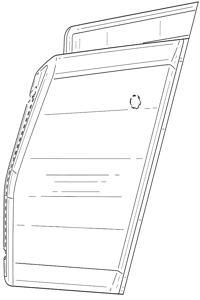

['laptop computer with antenna', 'front perspective view', 'laptop computer with antenna', 'front perspective view', 'electronic book with hinge connected touch screen', 'isometric view', 'display device with cameras', 'perspective view', 'display device with cameras', 'perspective view', 'protecting enclosure for portable electronic device', 'perspective view', 'cigar training kit', 'front perspective view', 'bumper for a utility vehicle', 'right side view', 'wireless transmitter', 'front , left and bottom perspective view']


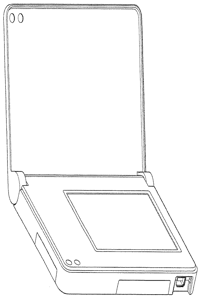

['laptop computer with antenna', 'front perspective view', 'laptop computer with antenna', 'front perspective view', 'electronic book with hinge connected touch screen', 'isometric view', 'display device with cameras', 'perspective view', 'display device with cameras', 'perspective view', 'protecting enclosure for portable electronic device', 'perspective view', 'cigar training kit', 'front perspective view', 'bumper for a utility vehicle', 'right side view', 'wireless transmitter', 'front , left and bottom perspective view']


In [258]:
for pic in images:
    for j in pic:
        print(j)

<PIL.Image.Image image mode=RGB size=200x300 at 0x7FEC502F6190>
laptop computer with antenna
front perspective view
<PIL.Image.Image image mode=RGB size=200x300 at 0x7FEBFCA7A110>
laptop computer with antenna
front perspective view
<PIL.Image.Image image mode=RGB size=200x300 at 0x7FEC624C4390>
electronic book with hinge connected touch screen
isometric view
<PIL.Image.Image image mode=RGB size=200x300 at 0x7FEC624C4FD0>
display device with cameras
perspective view
<PIL.Image.Image image mode=RGB size=200x300 at 0x7FEC624C4E90>
display device with cameras
perspective view
<PIL.Image.Image image mode=RGB size=200x300 at 0x7FEC624C4850>
protecting enclosure for portable electronic device
perspective view
<PIL.Image.Image image mode=RGB size=200x300 at 0x7FEC624CCAD0>
cigar training kit
front perspective view
<PIL.Image.Image image mode=RGB size=200x300 at 0x7FEC624CC9D0>
bumper for a utility vehicle
right side view
<PIL.Image.Image image mode=RGB size=200x300 at 0x7FEC624CC710>
wireless 